## Actual original notebook cells to do the work ...

In [1]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import glob
import matplotlib.pyplot as plt

/tmp/hoe01e.64743/ipykernel_34296/1559306108.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# only run this if above dask cluster cells are notrun
# comment out otherwise
from dask.distributed import Client, LocalCluster 
cluster = LocalCluster() # Launches a scheduler and workers locally 
client = Client(cluster)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43997 instead
  warnings.warn(


In [3]:
# get some pre-defined functions
# probably want to move them somewhere better more accessible
base_path = '/datasets/work/oa-vankirap/work/'
sys.path.append(f'{base_path}/schism/bin')
from SCHISM_load_plot_defs import schism_load, find_nearest_wet_point, schism_plot

### I've been using this package for EVA 
#### https://github.com/georgebv/pyextremes
See https://bitbucket.csiro.au/projects/CMEXTREMES/repos/cmextremes_py/browse/plotting/ww3_test_plot_ts_stats.ipynb
for example usage

In [4]:
from pyextremes import EVA

### This is the hourly 'elev' variable at selected coastal points, concatenated for the entire VanKIRAP Hindcast_v2
i.e.:
    /datasets/work/oa-vankirap/work/schism/Hindcast_v2

data created using:
    ClusterScale_VanKIRAP_SCHISM_extract.ipynb

In [5]:
# coastpoints_ds=xr.open_dataset(f'{base_path}/TWL_calc/coastal_points_schism_elev.nc', chunks='auto')
# coastpoints_ds=xr.load_dataset(f'{base_path}/schism/EVA/coastal_points_schism_elev.nc')
coastpoints_ds=xr.load_dataset(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev.nc')

In [6]:
coastpoints_ds

<xarray.Dataset>
Dimensions:    (index: 2377, time: 359424)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 2371 2372 2373 2374 2375 2376
  * time       (time) datetime64[ns] 1980-01-01T01:00:00 ... 2021-01-01
Data variables:
    longitude  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    latitude   (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.08 -13.07
    node_idx   (index) int64 97728 97735 97728 97922 ... 3238 3210 3141 3164
    kns        (index) int64 5 10 5 10 10 10 10 5 5 ... 10 10 10 5 10 10 10 10 5
    node_lons  (index) float64 169.8 169.8 169.8 169.8 ... 166.5 166.5 166.5
    node_lats  (index) float64 -20.25 -20.25 -20.25 ... -13.09 -13.09 -13.07
    depth      (index) float32 1.11 0.37 1.11 0.0 0.0 ... 24.12 7.08 19.89 2.71
    elev       (time, index) float32 -0.2643 -0.248 ... -0.04502 -0.04967

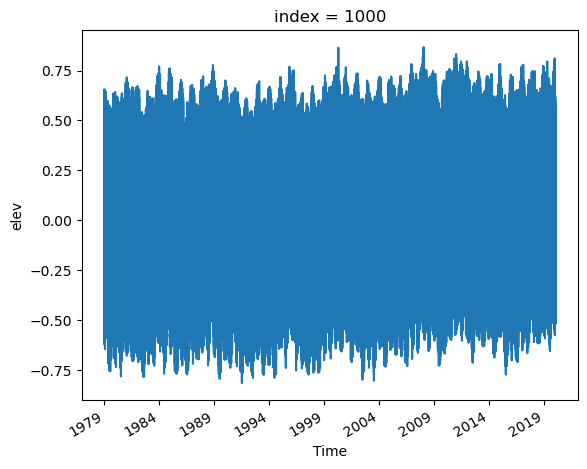

In [7]:
coastpoints_ds.isel(index=1000).elev.plot()

## Load latest SLR projection data for Vanuatu:
This comes from the Pacific Nextgen Project/SROCC projections:
https://www.rccap.org/uploads/files/2c538622-72fe-4f3d-a927-7b3a7149e73f/Vanuatu%20Country%20Report%20Final.pdf

In [29]:
# data path
slr_path = '/datasets/work/oa-sle/work/SeaLevel/Paccfic_SLR_SROCC/data_nc_files/SROCC_projection/'
rcps = ['rcp26','rcp45','rcp85']
# create dictionary of xr datasets associated with the SLR scenario files
ds_slr = {}
for rcp in rcps:
    ds_temp= xr.open_dataset(f'{slr_path}/sl_projection_Vanuatu_{rcp}.nc')
    ds_slr[rcp]=ds_temp.convert_calendar(calendar = 'gregorian',dim='TIME')
ds_slr[rcp]

<xarray.Dataset>
Dimensions:    (TIME: 94, bnds: 2)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2007-07-02T12:00:00 ... 2100-07-02T12:00:00
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (TIME, bnds) object 2007-01-01 00:00:00 ... 2101-01-01 00:00:00
    SL_MD      (TIME) float64 0.0332 0.037 0.04069 ... 0.868 0.886 0.8971
    SL_HIGH    (TIME) float64 0.04337 0.04821 0.05344 ... 1.173 1.199 1.219
    SL_LOW     (TIME) float64 0.02393 0.02699 0.02919 ... 0.6596 0.6729 0.6761
Attributes:
    history:      FERRET V6.84    4-Jun-21
    Conventions:  CF-1.0

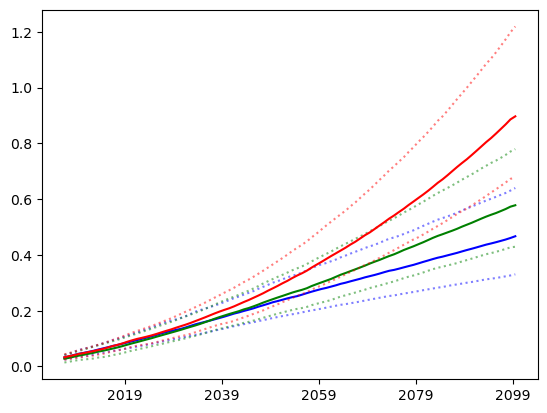

In [30]:
# Check plot? Should look like a simple version of Figure 5.2 in the above Pacific Nextgen Vanuatu report

colors = ['b','g','r']
slr_vars = ['SL_MD','SL_HIGH','SL_LOW']
fig, ax = plt.subplots(1, 1)
for ix,rcp in enumerate(rcps):
    c = colors[ix]
    x = ds_slr[rcp].indexes['TIME'].values
    for v in slr_vars:
        if v=='SL_MD':
            ax.plot(x,ds_slr[rcp][v],f'{c}')
        else:
            ax.plot(x,ds_slr[rcp][v],f':{c}', alpha=0.5)

In [31]:
# Create time slices means of the data coinciding with the other VanKIRAP activities.

Years = [2030,2050,2070,2090]
idx = pd.MultiIndex.from_product([Years,
                                  rcps],
                                 names=['Years', 'RCP'])
col = ['Median', 'lower (5%) CI', 'upper (95%) CI']

df_slr = pd.DataFrame('-', idx, col)

for year in Years:
    for rcp in rcps:
        start_time = f'{year}-01-01'
        end_time   = f'{year+1}-01-01'
        ds_temp = ds_slr[rcp].sel(TIME=slice(start_time,end_time))
        df_slr.loc[(year,rcp),'Median']=ds_temp.SL_MD.mean().values
        df_slr.loc[(year,rcp),'lower (5%) CI']=ds_temp.SL_LOW.mean().values
        df_slr.loc[(year,rcp),'upper (95%) CI']=ds_temp.SL_HIGH.mean().values
            

In [33]:
# %precision %.3f
# pd.set_option("display.precision", 3)
# pd.options.display.float_format = '{:.3f}'.format
# df_slr.style.format('{:.3}')

## Compare Extremes calculated by:
1. adding the sea level rise scenarios to the hourly water level data and then calculating EVA
2. calculate EVA on the the hourly water levels, and then add sea level rise scenarios to the resulting AEPs/ARIs

In [34]:
## Add in the hights SLR scenario
SLR_scenario = df_slr.loc[(2090,'rcp85'),'upper (95%) CI']
data = coastpoints_ds.elev.isel(index=0).to_series() + SLR_scenario
data

time
1980-01-01 01:00:00    0.735152
1980-01-01 02:00:00    0.935884
1980-01-01 03:00:00    1.194331
1980-01-01 04:00:00    1.440719
1980-01-01 05:00:00    1.609968
                         ...   
2020-12-31 20:00:00    1.459894
2020-12-31 21:00:00    1.496408
2020-12-31 22:00:00    1.443498
2020-12-31 23:00:00    1.317851
2021-01-01 00:00:00    1.162617
Name: elev, Length: 359424, dtype: float32

In [35]:
return_period = [10, 50, 100]
dist_params = ['thres/loc', 'c', 'scale']

model = EVA(data)
thres = np.percentile(data, 99.)
model.get_extremes(method="POT", threshold=thres, r="24H")
model.fit_model()

summary_SLR = model.get_summary(return_period=return_period, alpha=0.95)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='elev'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='elev', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

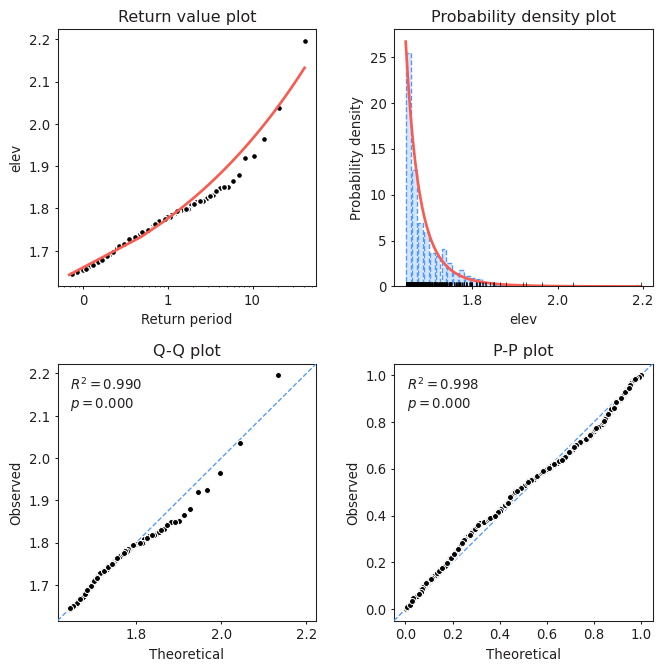

In [36]:
model.plot_diagnostic()

In [37]:
# Calculate EVA before adding SLR
data = coastpoints_ds.elev.isel(index=0).to_series()
return_period = [10, 50, 100]
dist_params = ['thres/loc', 'c', 'scale']

model = EVA(data)
thres = np.percentile(data, 99.)
model.get_extremes(method="POT", threshold=thres, r="24H")
model.fit_model()

summary = model.get_summary(return_period=return_period, alpha=0.95)

In [38]:
# model.plot_diagnostic()

In [39]:
summary_SLR

,return value,lower ci,upper ci
return period,,,
10.0,1.965003,1.902012,2.036793
50.0,2.159797,2.013273,2.331038
100.0,2.265271,2.069403,2.511055


In [40]:
summary[['return value','lower ci','upper ci']]=summary[['return value','lower ci','upper ci']]  + SLR_scenario

In [41]:
summary

,return value,lower ci,upper ci
return period,,,
10.0,1.965003,1.898178,2.043439
50.0,2.159797,2.003437,2.375248
100.0,2.265271,2.055614,2.578671


### Soo ... the methods are very, very slightly different - but are we OK to just use the latter method?
i.e. calculate EVA on the the hourly water levels, and then add sea level rise scenarios to the resulting AEPs/ARIs ?
- this saves a lot of EVA computation

In [43]:
EVA_df = pd.read_csv(f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev_POT_p99_8_GPD_ARI_20230718.csv')

In [44]:
EVA_df.columns

Index(['index', 'longitude', 'latitude', 'node_idx', 'kns', 'node_lons',
       'node_lats', 'depth', 'mean', 'max', 'p99', 'p99.8', 'R', 'c', 'scale',
       '10', '10 lower ci', '10 upper ci', '50', '50 lower ci', '50 upper ci',
       '100', '100 lower ci', '100 upper ci'],
      dtype='object')

In [45]:
EVA_df=EVA_df.rename(columns={'10':'10-year ARI',
               '10 lower ci': '10-year lower ci',
               '10 upper ci':'10-year upper ci',
               '50': '50-year ARI', 
               '50 lower ci': '50-year lower ci',
               '50 upper ci': '50-year upper ci', 
               '100':'100-year ARI',
               '100 lower ci':'100-year lower ci',
               '100 upper ci':'100-year upper ci'})

In [46]:
today = pd.Timestamp('today')
# print(f'{base_path}/schism/EVA/coastal_points_schism_elev_EVA_POT_ARI_baseline_v{today:%Y%m%d}.csv')

In [47]:
EVA_df.drop(columns=['index']).to_csv(
    f'{base_path}/schism/EVA/Hindcast_v3_coastal_points_schism_elev_POT_p99_8_GPD_ARI_{today:%Y%m%d}.csv', 
        index=False)

In [48]:
EVA_ds_projs={}
    # EVA_ds_projs[f'{rcp}']=EVA_df.drop([['index', 'longitude', 'latitude', 'kns', 'node_lons',
    #    'node_lats', 'depth', 'mean', 'max', 'p99', 'R', 'c', 'scale']])
for rcp in rcps:
    EVA_ds_projs[f'{rcp}']=EVA_df.drop(columns=['index','longitude', 'latitude', 'kns', 'depth', 'mean', 'max', 'p99', 'R', 'c', 'scale'])
    for year in Years:
        slr = df_slr.loc[(year,rcp),'Median']
        slr_l = df_slr.loc[(year,rcp),'lower (5%) CI']
        slr_h = df_slr.loc[(year,rcp),'upper (95%) CI']
        for rt in return_period:
            EVA_ds_projs[f'{rcp}'][f'{year} {rt}-year ARI']=EVA_ds_projs[f'{rcp}'][f'{rt}-year ARI']+slr
            EVA_ds_projs[f'{rcp}'][f'{year} {rt}-year lower ci']=EVA_ds_projs[f'{rcp}'][f'{rt}-year lower ci']+slr_l
            EVA_ds_projs[f'{rcp}'][f'{year} {rt}-year upper ci']=EVA_ds_projs[f'{rcp}'][f'{rt}-year upper ci']+slr_h
    EVA_ds_projs[f'{rcp}']=EVA_ds_projs[f'{rcp}'].drop(columns=['10-year ARI', '10-year lower ci', '10-year upper ci', '50-year ARI',
       '50-year lower ci', '50-year upper ci', '100-year ARI','100-year lower ci', '100-year upper ci'])

In [49]:
rcps

['rcp26', 'rcp45', 'rcp85']

In [50]:
for rcp in rcps:
    EVA_ds_projs[f'{rcp}'].to_csv(
        f'{base_path}/schism/EVA/coastal_points_schism_elev_EVA_POT_ARI_{rcp}_v{today:%Y%m%d}.csv', 
        index=False)

In [51]:
pd.options.display.float_format = '{:.3f}'.format
EVA_df.drop(columns=['index']).head()


,longitude,latitude,node_idx,kns,node_lons,node_lats,depth,mean,max,p99,...,scale,10-year ARI,10-year lower ci,10-year upper ci,50-year ARI,50-year lower ci,50-year upper ci,100-year ARI,100-year lower ci,100-year upper ci
0,169.773,-20.247,97728,5,169.772,-20.246,1.110,0.027,1.196,0.644,...,0.023,0.919,0.860,0.996,1.110,0.945,1.401,1.231,0.986,1.714
1,169.771,-20.250,97735,10,169.772,-20.255,0.370,0.072,1.424,0.679,...,0.033,1.008,0.929,1.117,1.237,1.023,1.584,1.377,1.072,1.924
2,169.773,-20.247,97728,5,169.772,-20.246,1.110,0.027,1.196,0.644,...,0.023,0.919,0.870,0.996,1.110,0.968,1.356,1.231,1.021,1.620
3,169.794,-20.236,97922,10,169.796,-20.238,0.000,0.035,1.222,0.647,...,0.024,0.912,0.858,0.976,1.081,0.938,1.333,1.184,0.979,1.609
4,169.799,-20.238,97922,10,169.796,-20.238,0.000,0.035,1.222,0.647,...,0.024,0.912,0.862,0.993,1.081,0.933,1.379,1.184,0.964,1.692


In [52]:
len(EVA_df.index)

2377

In [53]:
EVA_ds_projs['rcp85'].head()

,node_idx,node_lons,node_lats,p99.8,2030 10-year ARI,2030 10-year lower ci,2030 10-year upper ci,2030 50-year ARI,2030 50-year lower ci,2030 50-year upper ci,...,2070 100-year upper ci,2090 10-year ARI,2090 10-year lower ci,2090 10-year upper ci,2090 50-year ARI,2090 50-year lower ci,2090 50-year upper ci,2090 100-year ARI,2090 100-year lower ci,2090 100-year upper ci
0,97728,169.772,-20.246,0.723,1.058,0.965,1.177,1.249,1.050,1.581,...,2.349,1.662,1.426,1.996,1.853,1.511,2.401,1.974,1.552,2.713
1,97735,169.772,-20.255,0.767,1.147,1.034,1.297,1.375,1.128,1.764,...,2.559,1.751,1.495,2.116,1.980,1.589,2.583,2.120,1.638,2.923
2,97728,169.772,-20.246,0.723,1.058,0.975,1.176,1.249,1.073,1.536,...,2.255,1.662,1.436,1.995,1.853,1.534,2.355,1.974,1.587,2.619
3,97922,169.796,-20.238,0.728,1.051,0.963,1.156,1.220,1.043,1.513,...,2.244,1.655,1.424,1.976,1.824,1.504,2.332,1.927,1.545,2.609
4,97922,169.796,-20.238,0.728,1.051,0.967,1.173,1.220,1.038,1.560,...,2.327,1.655,1.428,1.993,1.824,1.499,2.379,1.927,1.530,2.692


In [54]:
EVA_ds_projs['rcp85'].columns

Index(['node_idx', 'node_lons', 'node_lats', 'p99.8', '2030 10-year ARI',
       '2030 10-year lower ci', '2030 10-year upper ci', '2030 50-year ARI',
       '2030 50-year lower ci', '2030 50-year upper ci', '2030 100-year ARI',
       '2030 100-year lower ci', '2030 100-year upper ci', '2050 10-year ARI',
       '2050 10-year lower ci', '2050 10-year upper ci', '2050 50-year ARI',
       '2050 50-year lower ci', '2050 50-year upper ci', '2050 100-year ARI',
       '2050 100-year lower ci', '2050 100-year upper ci', '2070 10-year ARI',
       '2070 10-year lower ci', '2070 10-year upper ci', '2070 50-year ARI',
       '2070 50-year lower ci', '2070 50-year upper ci', '2070 100-year ARI',
       '2070 100-year lower ci', '2070 100-year upper ci', '2090 10-year ARI',
       '2090 10-year lower ci', '2090 10-year upper ci', '2090 50-year ARI',
       '2090 50-year lower ci', '2090 50-year upper ci', '2090 100-year ARI',
       '2090 100-year lower ci', '2090 100-year upper ci'],
      dty